<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)

#X_train, y_train = get_train_data()
X_test, y_test = get_test_data(
    path="/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers"
)


#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [5]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)



# Comptage par classe
counts = lab_df.value_counts()

# Total
total = counts.sum()

# Pourcentages
percentages = (counts / total) * 100

# Ordre voulu pour le tableau
order = [
    "Cancer_cells",
    "NK_cells",
    "T_cells_CD4+",
    "T_cells_CD8+"
]

# Création du tableau final
table = pd.DataFrame({
    "Nombre de cellules": counts,
    "Proportion (%)": percentages.round(2)
}).loc[order]

print(table)
print("\nTotal :", total)



              Nombre de cellules  Proportion (%)
label                                           
Cancer_cells                 237            23.7
NK_cells                      85             8.5
T_cells_CD4+                 336            33.6
T_cells_CD8+                 342            34.2

Total : 1000


In [ ]:
from sklearn.metrics import balanced_accuracy_score

# NEW

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt


def preprocess_X(X_sparse):
    """
    Convertir un tableau sparse en dense et normaliser chaque ligne.
    """
    X = X_sparse.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier:
    def __init__(self, n_components=50, max_depth=5, n_estimators=100, max_features=3, random_state=42):
        self.pipe = make_pipeline(
            StandardScaler(),
            PCA(n_components=n_components, random_state=random_state),
            RandomForestClassifier(
                max_depth=max_depth, n_estimators=n_estimators, 
                max_features=max_features, random_state=random_state
            )
        )
        
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
    
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


def oversample(X, y, random_state=42):
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    resampled_idx = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        idx_resampled = resample(idx, replace=True, n_samples=max_count, random_state=random_state)
        resampled_idx.extend(idx_resampled)
    resampled_idx = np.array(resampled_idx)
    return X[resampled_idx], y[resampled_idx]


def binarize_labels(y, mapping):
    return np.array([mapping[label] for label in y])


def stratified_cv(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    acc_scores = []
    bal_acc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        clf = Classifier(n_components=50)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        acc_scores.append(accuracy_score(y_val, y_pred))
        bal_acc_scores.append(balanced_accuracy_score(y_val, y_pred))
        print(f"Fold {fold}: Accuracy={acc_scores[-1]:.4f}, Balanced Accuracy={bal_acc_scores[-1]:.4f}")
    return np.mean(acc_scores), np.mean(bal_acc_scores)


def train_final_classifier(X, y, n_components=50):
    clf = Classifier(n_components=n_components)
    clf.fit(X, y)
    return clf


def train_group_classifiers(X, y_binary, y_original, n_components=50):
    classifiers = {}
    for group in np.unique(y_binary):
        mask = y_binary == group
        clf = Classifier(n_components=n_components)
        clf.fit(X[mask], y_original[mask])
        classifiers[group] = clf
    return classifiers


def predict_final(X_test, clf_binary, classifiers_group):
    y_test_binary_pred = clf_binary.predict(X_test)
    y_test_final = np.empty_like(y_test_binary_pred, dtype=object)
    for group, clf in classifiers_group.items():
        mask = y_test_binary_pred == group
        y_test_final[mask] = clf.predict(X_test[mask])
    return y_test_final




In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# --- 1️⃣ Fonctions utilitaires ---

def log_normalize(X):
    """Log-normalisation type log1p sur les données"""
    X = X.toarray() if hasattr(X, "toarray") else X
    return np.log1p(1 + X)

def oversample(X, y, random_state=42):
    """Oversampling pour équilibrer les classes"""
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    resampled_idx = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        idx_resampled = resample(idx, replace=True, n_samples=max_count, random_state=random_state)
        resampled_idx.extend(idx_resampled)
    resampled_idx = np.array(resampled_idx)
    return X[resampled_idx], y[resampled_idx]

# --- 2️⃣ Classe Classifier ---

class Classifier:
    """
    Classifier avec oversampling, log-normalisation, PCA/TruncatedSVD,
    double classification (binaire puis sous-classes)
    """
    def __init__(self, n_components=50, max_depth=None, n_estimators=100,
                 max_features='sqrt', random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.max_features = max_features

        # Modèle binaire (classe regroupée)
        self.clf_binary = make_pipeline(
            FunctionTransformer(log_normalize, validate=False),
            TruncatedSVD(n_components=self.n_components, random_state=self.random_state),
            RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state
            )
        )

        # Sous-modèles pour chaque groupe
        self.group_classifiers = {}

    def fit(self, X, y, binary_map):
        """
        X : tableau numpy ou sparse
        y : labels originaux
        binary_map : dict pour regrouper les classes en binaire
        """
        # 1️⃣ Oversampling
        X_res, y_res = oversample(X, y, random_state=self.random_state)

        # 2️⃣ Création des labels binaires
        y_binary = np.array([binary_map[label] for label in y_res])

        # 3️⃣ Entraînement du modèle binaire
        self.clf_binary.fit(X_res, y_binary)

        # 4️⃣ Entraînement des sous-modèles pour chaque groupe
        for group in np.unique(y_binary):
            mask = y_binary == group
            clf = make_pipeline(
                FunctionTransformer(log_normalize, validate=False),
                TruncatedSVD(n_components=self.n_components, random_state=self.random_state),
                RandomForestClassifier(
                    n_estimators=self.n_estimators,
                    max_depth=self.max_depth,
                    max_features=self.max_features,
                    random_state=self.random_state
                )
            )
            clf.fit(X_res[mask], y_res[mask])
            self.group_classifiers[group] = clf

    def predict(self, X):
        """
        Prédiction finale après double classification
        """
        # 1️⃣ Prédiction binaire
        y_binary_pred = self.clf_binary.predict(X)

        # 2️⃣ Prédiction des sous-classes
        y_final = np.empty_like(y_binary_pred, dtype=object)
        for group, clf in self.group_classifiers.items():
            mask = y_binary_pred == group
            y_final[mask] = clf.predict(X[mask])
        return y_final

    def predict_proba(self, X):
        """
        Probabilités finales (optionnel)
        """
        y_binary_pred = self.clf_binary.predict(X)
        y_proba = np.zeros((X.shape[0], len(np.unique(y_binary_pred))))
        for i, group in enumerate(np.unique(y_binary_pred)):
            mask = y_binary_pred == group
            y_proba[mask, i] = self.group_classifiers[group].predict_proba(X[mask])[:, 1]  # colonne 1
        return y_proba


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

# --- Paramètres ---
n_splits = 5
random_state = 42

# Exemple de binary_map pour regroupement des classes
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}

# --- Stockage des scores ---
bal_acc_scores = []

# --- Stratified K-Fold ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_log, y_train), 1):
    # Split train/validation
    X_tr, X_val = X_train_log[train_idx], X_train_log[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Création et entraînement du Classifier
    clf = Classifier(n_components=600, max_depth=5, n_estimators=100, max_features=3, random_state=random_state)
    clf.fit(X_tr, y_tr, binary_map)

    # Prédiction sur la validation
    y_val_pred = clf.predict(X_val)

    # Calcul de la balanced accuracy
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    bal_acc_scores.append(bal_acc)
    print(f"Fold {fold}: Balanced Accuracy = {bal_acc:.4f}")

# --- Moyenne des scores ---
print(f"\nMean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")


TypeError: Classifier.fit() takes 3 positional arguments but 4 were given

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Paramètres ---
n_splits = 5
random_state = 42

# Exemple de binary_map pour regroupement des classes
binary_map = {
    "T_cells_CD4+": "Classe_1",
    "T_cells_CD8+": "Classe_1",
    "Cancer_cells": "Classe_2",
    "NK_cells": "Classe_2"
}

# --- Stockage des résultats ---
bal_acc_scores = []
y_true_all = []
y_pred_all = []

# --- Stratified K-Fold ---
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_log, y_train), 1):
    # Split train/validation
    X_tr, X_val = X_train_log[train_idx], X_train_log[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Création et entraînement du Classifier
    clf = Classifier(n_components=600, max_depth=5, n_estimators=100, max_features=3, random_state=random_state)
    clf.fit(X_tr, y_tr, binary_map)

    # Prédiction sur la validation
    y_val_pred = clf.predict(X_val)

    # Stockage pour confusion matrix globale
    y_true_all.extend(y_val)
    y_pred_all.extend(y_val_pred)

    # Calcul de la balanced accuracy pour ce fold
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    bal_acc_scores.append(bal_acc)
    print(f"Fold {fold}: Balanced Accuracy = {bal_acc:.4f}")

# --- Moyenne des scores ---
print(f"\nMean Balanced Accuracy: {np.mean(bal_acc_scores):.4f}")

# --- Matrice de confusion globale ---
cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - K-Fold")
plt.show()


TypeError: Classifier.fit() takes 3 positional arguments but 4 were given

## Méthode 1 : Log normalisation + ACP + augmentation de donnees + Random forest 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier


class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)

        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()

        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]

            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)

        X_bal = np.array(X_bal)

        # PCA fitting
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)

        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values

        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
             n_jobs=-1
)
    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(
            self.preprocessor.X_train_,
            self.preprocessor.y_train_
        )

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


In [ ]:
# Initialisation du classifieur
clf = Classifier()

# Entraînement sur les données d'entraînement
clf.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)


In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score
)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

if len(np.unique(y_test)) == 2:
    print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))


              precision    recall  f1-score   support

Cancer_cells       0.96      0.97      0.97       118
    NK_cells       1.00      0.23      0.38        43
T_cells_CD4+       0.82      0.90      0.86       168
T_cells_CD8+       0.77      0.83      0.80       171

    accuracy                           0.84       500
   macro avg       0.89      0.73      0.75       500
weighted avg       0.85      0.84      0.82       500

Confusion Matrix:
 [[115   0   2   1]
 [  0  10   7  26]
 [  1   0 151  16]
 [  4   0  25 142]]
Accuracy: 0.836
Balanced Accuracy: 0.7340883228139986


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score


def kfold_evaluation(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    balanced_accuracies = []

    fold = 1

    for train_idx, test_idx in skf.split(X, y):
        print(f"\nFold {fold}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        accuracies.append(acc)
        balanced_accuracies.append(bal_acc)

        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")

        fold += 1

    print("\n=== Résultats globaux ===")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Mean Balanced Accuracy: {np.mean(balanced_accuracies):.4f} ± {np.std(balanced_accuracies):.4f}")

    return accuracies, balanced_accuracies


accuracies, balanced_accuracies = kfold_evaluation(X_test, y_test, n_splits=5)



Fold 1
Accuracy: 0.8200
Balanced Accuracy: 0.7247

Fold 2
Accuracy: 0.8000
Balanced Accuracy: 0.7029

Fold 3
Accuracy: 0.8000
Balanced Accuracy: 0.6587

Fold 4
Accuracy: 0.8100
Balanced Accuracy: 0.6921

Fold 5
Accuracy: 0.8800
Balanced Accuracy: 0.8266

=== Résultats globaux ===
Mean Accuracy: 0.8220 ± 0.0299
Mean Balanced Accuracy: 0.7210 ± 0.0569


## Méthode 2 : Log normalisation + ACP + augmentation + radom forest + classification en deux temps 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# On garde ton Preprocessor tel quel
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]

            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1
        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# Classifier unique avec RandomForest et Preprocessor
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(
            self.preprocessor.X_train_,
            self.preprocessor.y_train_
        )

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# -------- HierarchicalClassifier --------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()  # Healthy vs Infected
        self.clf_step2 = Classifier()  # Viral vs Bacterial

    def fit(self, X, y):
        # STEP 1: Healthy vs Infected
        y_step1 = np.where(y == 0, 0, 1)
        self.clf_step1.fit(X, y_step1)

        # STEP 2: Viral vs Bacterial (infected only)
        infected_mask = y != 0
        X_step2 = X[infected_mask]
        y_step2 = y[infected_mask]
        y_step2 = np.where(y_step2 == 1, 0, 1)  # Viral=0, Bacterial=1

        self.clf_step2.fit(X_step2, y_step2)

    def predict(self, X):
        # STEP 1
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.zeros(len(step1_pred), dtype=int)

        # STEP 2
        infected_idx = np.where(step1_pred == 1)[0]
        if len(infected_idx) > 0:
            step2_pred = self.clf_step2.predict(X[infected_idx])
            final_pred[infected_idx] = step2_pred + 1  # Remap: 0->Viral(1),1->Bacterial(2)

        return final_pred


In [ ]:
hc = HierarchicalClassifier()
hc.fit(X_train, y_train)

y_pred = hc.predict(X_test)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()          # Step1: Group1 vs Group2
        self.clf_step2_group1 = Classifier()   # Step2: Cancer vs NK
        self.clf_step2_group2 = Classifier()   # Step2: CD4+ vs CD8+

    def fit(self, X, y):
        # Step 1: Group1 (Cancer_cells, NK_cells) vs Group2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Step 2: classifier pour chaque groupe
        mask_group1 = [label in ['Cancer_cells','NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        mask_group2 = [label in ['T_cells_CD4+','T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Group1 : Cancer vs NK
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1)>0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Group2 : CD4+ vs CD8+
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2)>0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)



Classification Report:
              precision    recall  f1-score   support

Cancer_cells       0.85      0.98      0.91        42
    NK_cells       0.89      0.50      0.64        16
T_cells_CD4+       0.84      0.70      0.76        66
T_cells_CD8+       0.75      0.87      0.80        76

    accuracy                           0.81       200
   macro avg       0.83      0.76      0.78       200
weighted avg       0.81      0.81      0.80       200

Balanced Accuracy: 0.7603953064479381
Confusion Matrix:
 [[41  0  1  0]
 [ 1  8  0  7]
 [ 4  1 46 15]
 [ 2  0  8 66]]


## Methode 3 : acp pour chaque classification 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Log transform
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Class balancing (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)

# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

Cancer_cells       0.89      0.95      0.92        42
    NK_cells       0.80      0.50      0.62        16
T_cells_CD4+       0.87      0.71      0.78        66
T_cells_CD8+       0.75      0.89      0.81        76

    accuracy                           0.81       200
   macro avg       0.83      0.76      0.78       200
weighted avg       0.82      0.81      0.81       200

Balanced Accuracy: 0.7648097516518569
Confusion Matrix:
 [[40  0  0  2]
 [ 0  8  1  7]
 [ 3  2 47 14]
 [ 2  0  6 68]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Stacking Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        # Modèle Stacking avec plusieurs modèles de base
        self.model = StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('svm', SVC(kernel='linear', probability=True, random_state=42))
            ],
            final_estimator=LogisticRegression()
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()          # Step1: Group1 vs Group2
        self.clf_step2_group1 = Classifier()   # Step2: Cancer vs NK
        self.clf_step2_group2 = Classifier()   # Step2: CD4+ vs CD8+

    def fit(self, X, y):
        # Step 1: Group1 (Cancer_cells, NK_cells) vs Group2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Step 2: classifier pour chaque groupe
        mask_group1 = [label in ['Cancer_cells','NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        mask_group2 = [label in ['T_cells_CD4+','T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Group1 : Cancer vs NK
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1)>0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Group2 : CD4+ vs CD8+
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2)>0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation du classifieur hiérarchique avec Stacking
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Calcul de la balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

# Matrice de confusion
cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


NameError: name 'X_train' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Stacking Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        # Modèle Stacking avec plusieurs modèles de base
        self.model = StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('svm', SVC(kernel='linear', probability=True, random_state=42))
            ],
            final_estimator=LogisticRegression()
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Classification en deux étapes ----------------
class HierarchicalClassifier:
    def __init__(self):
        self.clf_step1 = Classifier()  # Étape 1 : Groupe 1 vs Groupe 2
        self.clf_step2_group1 = Classifier()  # Étape 2 : Cancer vs NK
        self.clf_step2_group2 = Classifier()  # Étape 2 : CD4+ vs CD8+

    def fit(self, X, y):
        # Étape 1 : Séparer Groupe 1 (Cancer_cells, NK_cells) vs Groupe 2 (T_cells_CD4+, T_cells_CD8+)
        y_step1 = np.array([0 if label in ['Cancer_cells', 'NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Étape 2 : Séparer pour Groupe 1 : Cancer_cells vs NK_cells
        mask_group1 = [label in ['Cancer_cells', 'NK_cells'] for label in y]
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label == 'Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Étape 2 : Séparer pour Groupe 2 : T_cells_CD4+ vs T_cells_CD8+
        mask_group2 = [label in ['T_cells_CD4+', 'T_cells_CD8+'] for label in y]
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label == 'T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        # Étape 1 : Séparation entre les deux groupes
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""] * len(step1_pred), dtype=object)

        # Groupe 1 : Cancer_cells vs NK_cells
        idx_group1 = np.where(step1_pred == 0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p == 0 else "NK_cells" for p in pred_group1]

        # Groupe 2 : T_cells_CD4+ vs T_cells_CD8+
        idx_group2 = np.where(step1_pred == 1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p == 0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données
# X_train, y_train, X_test, y_test

# Initialisation du classifieur avec les étapes
hier_clf = HierarchicalClassifier()

# Entraînement du modèle
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calcul de l'accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Calcul de la balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

# Matrice de confusion
cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.99      1.00       118
    NK_cells       1.00      0.47      0.63        43
T_cells_CD4+       0.87      0.87      0.87       168
T_cells_CD8+       0.79      0.90      0.84       171

    accuracy                           0.87       500
   macro avg       0.91      0.81      0.84       500
weighted avg       0.88      0.87      0.87       500

Accuracy: 0.874
Balanced Accuracy: 0.8065685292919593
Confusion Matrix:
 [[117   0   1   0]
 [  0  20   3  20]
 [  0   0 146  22]
 [  0   0  17 154]]


## supp de gène 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred



# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = HierarchicalClassifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.95      0.97       118
    NK_cells       0.91      0.47      0.62        43
T_cells_CD4+       0.84      0.87      0.86       168
T_cells_CD8+       0.80      0.90      0.85       171

    accuracy                           0.86       500
   macro avg       0.89      0.80      0.82       500
weighted avg       0.87      0.86      0.86       500

Balanced Accuracy: 0.7959753089529763
Confusion Matrix:
 [[112   0   6   0]
 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        
        # Initialisation du modèle avec les paramètres optimaux obtenus
        self.model = SVC(C=10, kernel='rbf', gamma='scale', degree=3, random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Entraîner le modèle
        self.model.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42)

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)

# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred



# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from GridSearchCV: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.98      0.99       118
    NK_cells       0.89      0.56      0.69        43
T_cells_CD4+       0.84      0.87      0.86       168
T_cells_CD8+       0.80      0.87      0.83       171

    accuracy                           0.87       500
   macro avg       0.88      0.82      0.84       500
weighted avg       0.87      0.87      0.87       500

Balanced Accuracy: 0.8189337693530898
Confusion Matrix:
 [[116   0   

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class Classifier(object):
    def __init__(self):
        self.le = LabelEncoder()
        self.kept_idx = None  # indices des gènes conservés

        # Base estimators pour StackingClassifier
        rf = RandomForestClassifier(n_estimators=200, max_depth=50,
                                    max_features="sqrt",
                                    random_state=42)
        svc = SVC(kernel="rbf", probability=True, C=1.0, gamma="scale",
                  random_state=42)
        knn = KNeighborsClassifier(n_neighbors=15)

        stack = StackingClassifier(
            estimators=[("rf", rf), ("svc", svc), ("knn", knn)],
            final_estimator=LogisticRegression(max_iter=10000, solver="lbfgs"),
            n_jobs=-1,
            passthrough=False
        )

        # Pipeline avec prétraitement PCA et StackingClassifier
        self.pipe = make_pipeline(
            PCA(n_components=60, random_state=42),
            stack
        )

    def _preprocess_X(self, X, fit=False):
        # Supprimer les gènes peu variables
        if fit:
            X_filtered, self.kept_idx = remove_genes(X, threshold=0.01)
        else:
            # Appliquer le même masque que pour le train
            if self.kept_idx is None:
                raise ValueError("Kept indices are not set.")
            if hasattr(X, "toarray"):
                X = X.toarray()
            X_filtered = X[:, self.kept_idx]

        # Normalisation par taille de bibliothèque et log1p
        if hasattr(X_filtered, "toarray"):
            X_filtered = X_filtered.toarray()
        libsize = X_filtered.sum(axis=1)[:, None]
        libsize[libsize == 0] = 1
        X_processed = np.log1p(X_filtered / libsize * 1e4)
        return X_processed

    def fit(self, X_sparse, y):
        X = self._preprocess_X(X_sparse, fit=True)
        y_enc = self.le.fit_transform(y)
        self.pipe.fit(X, y_enc)
        self.classes_ = self.le.classes_

    def predict(self, X_sparse):
        X = self._preprocess_X(X_sparse, fit=False)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self._preprocess_X(X_sparse, fit=False)
        return self.pipe.predict_proba(X)


# ---------------- Hierarchical Classifier ----------------
class HierarchicalClassifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = Classifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = Classifier()  # Cancer vs NK
        self.clf_step2_group2 = Classifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells', 'NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells', 'NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label == 'Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+', 'T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label == 'T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""] * len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred == 0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p == 0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred == 1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p == 0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        step1_pred_proba = self.clf_step1.predict_proba(X)
        final_pred_proba = np.zeros_like(step1_pred_proba, dtype=float)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred_proba[:, 0] > 0)[0]
        if len(idx_group1) > 0:
            pred_group1_proba = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_pred_proba[idx_group1] = pred_group1_proba

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred_proba[:, 1] > 0)[0]
        if len(idx_group2) > 0:
            pred_group2_proba = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_pred_proba[idx_group2] = pred_group2_proba

        return final_pred_proba


In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, variance_threshold=0.80):
        self.variance_threshold = variance_threshold
        self.pca = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # PCA
        pca_tmp = PCA()
        pca_tmp.fit(X_bal)
        cum_var = np.cumsum(pca_tmp.explained_variance_ratio_)
        n_components = np.argmax(cum_var >= self.variance_threshold) + 1

        self.pca = PCA(n_components=n_components)
        self.pca.fit(X_bal)

        self.X_train_ = self.pca.transform(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return self.pca.transform(X)


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = SVC(random_state=42, probability=True)  

    def fit(self, X, y):
        # Appliquer le préprocesseur (PCA, normalisation, imputation)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.1, 1, 10],  # Paramètre de régularisation
            'kernel': ['linear', 'rbf'],  # Type de noyau
            'gamma': ['scale', 'auto'],  # Paramètre du noyau RBF
            'degree': [3, 4, 5]  # Degré du noyau polynomial (si applicable)
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        # Probabilités pour la première étape
        step1_prob = self.clf_step1.predict_proba(X)
        final_prob = np.zeros((len(X), 4))  # Probabilités pour 4 classes

        # Sous-groupe 1
        idx_group1 = np.where(step1_prob[:, 0] > step1_prob[:, 1])[0]
        if len(idx_group1) > 0:
            prob_group1 = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_prob[idx_group1, 0] = prob_group1[:, 0]
            final_prob[idx_group1, 1] = prob_group1[:, 1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_prob[:, 1] > step1_prob[:, 0])[0]
        if len(idx_group2) > 0:
            prob_group2 = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2, 2] = prob_group2[:, 0]
            final_prob[idx_group2, 3] = prob_group2[:, 1]

        return final_prob


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


KeyboardInterrupt: 

## Régression logistique 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# ---------------- Preprocessing RNA-seq avec oversampling ----------------
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
        return X

# ---------------- Classifier ----------------
class Classifier(object):
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),  # ajustable
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        # Appliquer le préprocesseur (log + oversampling)
        self.preprocessor.fit(X_sparse, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_
        self.pipe.fit(X_train, y_train)
        return self

    def predict(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict_proba(X)
    




In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

# ---------------- Preprocessing RNA-seq avec oversampling ----------------
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return X

# ---------------- Classifier multinomial ----------------
class Classifier(object):
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.pipe = Pipeline([
            
            ("select", SelectKBest(score_func=f_classif, k=4000)),  # ajustable
            ("clf", LogisticRegression(
                penalty="l2",
                solver="saga",
                multi_class="multinomial",  
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        self.preprocessor.fit(X_sparse, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_
        self.pipe.fit(X_train, y_train)
        return self

    def predict(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict(X)

    def predict_proba(self, X_sparse):
        X = self.preprocessor.transform(X_sparse)
        return self.pipe.predict_proba(X)

# ---------------- Exemple d'utilisation ----------------
# clf = Classifier()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_proba = clf.predict_proba(X_test)
# print(classification_report(y_test, y_pred))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# ---------------- Preprocessor avec oversampling, sans PCA ----------------
class Preprocessor:
    def fit(self, X, y):
        """
        Transformation log1p + normalisation par cellule (library size)
        avec oversampling pour équilibrer les classes
        """
        # Convertir en dense si sparse
        X = X.toarray() if hasattr(X, "toarray") else X
        X = np.log1p(X)  # Log transformation
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Oversampling pour équilibrer les classes
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42).to_numpy()
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42).to_numpy()

        # Normalisation par cellule
        X_bal = X_bal / (X_bal.sum(axis=1, keepdims=True) + 1e-8)

        self.X_train_ = X_bal
        self.y_train_ = y_bal
        return self

    def transform(self, X):
        X = X.toarray() if hasattr(X, "toarray") else X
        X = np.log1p(X)
        X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
        return X


# ---------------- HClassifier avec RandomForest ----------------
class HClassifier:
    def __init__(self, k_features=4000, n_estimators=500, max_depth=None):
        self.preprocessor = Preprocessor()
        self.selector = SelectKBest(score_func=f_classif, k=k_features)
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )

    def fit(self, X, y):
        self.preprocessor.fit(X, y)
        X_train = self.preprocessor.X_train_
        y_train = self.preprocessor.y_train_

        # Sélection des features
        X_train_sel = self.selector.fit_transform(X_train, y_train)

        # Entraîner le RandomForest
        self.model.fit(X_train_sel, y_train)

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        X_proc = self.selector.transform(X_proc)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        X_proc = self.selector.transform(X_proc)
        return self.model.predict_proba(X_proc)

# ---------------- Classifier hiérarchique ----------------
class Classifier:
    def __init__(self):
        self.clf_step1 = HClassifier()
        self.clf_step2_group1 = HClassifier()
        self.clf_step2_group2 = HClassifier()

    def fit(self, X, y):
        y_step1 = np.array([0 if lbl in ['Cancer_cells','NK_cells'] else 1 for lbl in y])
        self.clf_step1.fit(X, y_step1)

        mask_group1 = np.array([lbl in ['Cancer_cells','NK_cells'] for lbl in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if lbl=='Cancer_cells' else 1 for lbl in y[mask_group1]])
        )

        mask_group2 = np.array([lbl in ['T_cells_CD4+','T_cells_CD8+'] for lbl in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if lbl=='T_cells_CD4+' else 1 for lbl in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred

    def predict_proba(self, X):
        step1_prob = self.clf_step1.predict_proba(X)
        final_prob = np.zeros((len(X), 4))  # 4 classes

        idx_group1 = np.where(step1_prob[:,0] > step1_prob[:,1])[0]
        if len(idx_group1) > 0:
            prob_group1 = self.clf_step2_group1.predict_proba(X[idx_group1])
            final_prob[idx_group1,0] = prob_group1[:,0]
            final_prob[idx_group1,1] = prob_group1[:,1]

        idx_group2 = np.where(step1_prob[:,1] >= step1_prob[:,0])[0]
        if len(idx_group2) > 0:
            prob_group2 = self.clf_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2,2] = prob_group2[:,0]
            final_prob[idx_group2,3] = prob_group2[:,1]

        return final_prob


In [ ]:
# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)

/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# ======================================================
# 1. PREPROCESSING RNA-seq
# ======================================================
class Preprocessor:
    def __init__(self):
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        self.X_train_ = np.array(X_bal)
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        return X

# ======================================================
# 2. STACKING CLASSIFIER POUR SOUMISSION
# ======================================================
class Classifier(object):
    def __init__(self):
        # Base learners
        self.base_learners = [
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            )),
            ('knn', KNeighborsClassifier(
                n_neighbors=5,
                weights='distance',
                n_jobs=-1
            )),
            ('svc', SVC(
                C=1.0,
                kernel='rbf',
                gamma='scale',
                class_weight='balanced',
                probability=True,
                random_state=42
            ))
        ]

        # Meta-learner
        self.meta_learner = LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            max_iter=5000,
            class_weight='balanced',
            n_jobs=-1
        )

        # Stacking classifier
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("var_thresh", VarianceThreshold(threshold=1e-4)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("stack", StackingClassifier(
                estimators=self.base_learners,
                final_estimator=self.meta_learner,
                passthrough=True,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        X_proc = preprocess_X(X_sparse)
        self.pipe.fit(X_proc, y)
        return self

    def predict(self, X_sparse):
        X_proc = preprocess_X(X_sparse)
        return self.pipe.predict(X_proc)

    def predict_proba(self, X_sparse):
        X_proc = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X_proc)

# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====
Balanced accuracy (fold 1): 0.8313

===== Fold 2/5 =====
Balanced accuracy (fold 2): 0.8087

===== Fold 3/5 =====
Balanced accuracy (fold 3): 0.8200

===== Fold 4/5 =====
Balanced accuracy (fold 4): 0.8106

===== Fold 5/5 =====
Balanced accuracy (fold 5): 0.8438

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.8228784639002301
Std Balanced Accuracy: 0.013192594363480198

Classification Report (global):
              precision    recall  f1-score   support

Cancer_cells       0.97      0.98      0.98       237
    NK_cells       0.73      0.62      0.67        85
T_cells_CD4+       0.85      0.88      0.86       336
T_cells_CD8+       0.81      0.81      0.81       342

    accuracy                           0.86      1000
   macro avg       0.84      0.82      0.83      1000
weighted avg       0.86      0.86      0.86      1000

Confusion Matrix (global):
[[233   1   2   1]
 [  2  53   2  28]
 [  3   4 295  34]
 [  2  15  49 276]]


## Amélioration du modele de regression logistique

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)
 
 
def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
 
    return X
 
 
class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  #  à ajuster (1000–5000)
            )),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)
 
 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
    return X

class TwoStepClassifier(object):
    def __init__(self):
        # Étape 1 : Cancer vs Autres
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : Classification interne des autres cellules
        self.pipe_step2_others = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=f_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="l1",
                solver="saga",
                C=1.0,
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # Création du label binaire pour l'étape 1
        y_step1 = np.array([1 if label == "Cancer_cells" else 0 for label in y])
        self.pipe_step1.fit(X, y_step1)
        
        # Étape 2 : sous-groupe des "autres cellules"
        mask_others = y_step1 == 0
        X_others = X[mask_others]
        y_others = np.array([label for label in y[mask_others]])
        self.pipe_step2_others.fit(X_others, y_others)
        
        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_pred = self.pipe_step1.predict(X)
        final_pred = np.array([""] * len(X), dtype=object)
        
        # Cancer
        final_pred[step1_pred == 1] = "Cancer_cells"
        
        # Autres
        idx_others = np.where(step1_pred == 0)[0]
        if len(idx_others) > 0:
            pred_others = self.pipe_step2_others.predict(X[idx_others])
            final_pred[idx_others] = pred_others
        
        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_prob = self.pipe_step1.predict_proba(X)
        
        n_classes = len(np.unique(np.concatenate([["Cancer_cells"], self.pipe_step2_others.classes_])))
        final_prob = np.zeros((len(X), n_classes))
        
        # Cancer
        final_prob[:, 0] = step1_prob[:, 1]  # Probabilité Cancer
        
        # Autres
        idx_others = np.where(step1_prob[:, 0] >= step1_prob[:, 1])[0]
        if len(idx_others) > 0:
            prob_others = self.pipe_step2_others.predict_proba(X[idx_others])
            final_prob[idx_others, 1:] = prob_others
        
        return final_prob


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-8)
    return X

class TwoStepClassifier(object):
    def __init__(self, grid_search=False):
        self.grid_search = grid_search
        
        # Étape 1 : Cancer vs Autres
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=0.2)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : Classification interne des autres cellules
        self.pipe_step2_others = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=0.2)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Param grid pour GridSearch
        self.param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__l1_ratio": [0.2, 0.5, 0.8]
        }

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # Étape 1 : Cancer vs Autres
        y_step1 = np.array([1 if label == "Cancer_cells" else 0 for label in y])
        if self.grid_search:
            self.gs_step1 = GridSearchCV(
                self.pipe_step1,
                param_grid=self.param_grid,
                cv=5,
                scoring="balanced_accuracy",
                n_jobs=-1
            )
            self.gs_step1.fit(X, y_step1)
            self.pipe_step1 = self.gs_step1.best_estimator_
        else:
            self.pipe_step1.fit(X, y_step1)
        
        # Étape 2 : sous-groupe des "autres cellules"
        mask_others = y_step1 == 0
        X_others = X[mask_others]
        y_others = np.array([label for label in y[mask_others]])
        if self.grid_search:
            self.gs_step2 = GridSearchCV(
                self.pipe_step2_others,
                param_grid=self.param_grid,
                cv=5,
                scoring="balanced_accuracy",
                n_jobs=-1
            )
            self.gs_step2.fit(X_others, y_others)
            self.pipe_step2_others = self.gs_step2.best_estimator_
        else:
            self.pipe_step2_others.fit(X_others, y_others)
        
        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_pred = self.pipe_step1.predict(X)
        final_pred = np.array([""] * len(X), dtype=object)
        
        # Cancer
        final_pred[step1_pred == 1] = "Cancer_cells"
        
        # Autres
        idx_others = np.where(step1_pred == 0)[0]
        if len(idx_others) > 0:
            pred_others = self.pipe_step2_others.predict(X[idx_others])
            final_pred[idx_others] = pred_others
        
        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        step1_prob = self.pipe_step1.predict_proba(X)
        
        n_classes = len(np.unique(np.concatenate([["Cancer_cells"], self.pipe_step2_others.classes_])))
        final_prob = np.zeros((len(X), n_classes))
        
        # Cancer
        final_prob[:, 0] = step1_prob[:, 1]  # Probabilité Cancer
        
        # Autres
        idx_others = np.where(step1_prob[:, 0] >= step1_prob[:, 1])[0]
        if len(idx_others) > 0:
            prob_others = self.pipe_step2_others.predict_proba(X[idx_others])
            final_prob[idx_others, 1:] = prob_others
        
        return final_prob


In [ ]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 1): 0.8623

===== Fold 2/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  286   515   710   845  1466  1558  1594  2607  2820  2845  3769  3865
  4112  4156  4338  4659  4906  5433  5825  5885  6006  7825  8357  9606
  9630 10125 10139 10918 11371 11608 12177 12764 12768 12819 13099] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 2): 0.8788

===== Fold 3/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33   220   223   611  1016  1442  1606  2431  2433  2511  2594  3024
  3092  3176  3354  4166  4230  4714  5802  6775  7750  7913  8151  8712
  9592  9639  9730  9969 10047 10150 10583 10593 10840 11414 11745 13468] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 3): 0.8055

===== Fold 4/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  216   247   621   856  1370  1814  1830  2569  2827  2836  2853  3743
  4066  4361  4668  4671  4788  5286  6194  6717  7133  7476  7756  7969
  9557  9584  9610  9905 10038 10087 10370 11365 12225 12677 12684 12762
 12963 13249 13418] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 4): 0.8531

===== Fold 5/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   76  1576  1659  1664  1907  2001  2650  3101  3390  3856  4055  4510
  4513  4996  5174  5392  5607  5895  6053  6055  6098  6156  7975  8034
  8427  9201  9451  9575  9675  9687  9692 11052 11376 11602 11727 11881
 12237 12822 12872 13443] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KeyboardInterrupt: 

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def preprocess_X(X_sparse):
    X = X_sparse.toarray()
    X = np.log1p(X)
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
    return X

class Classifier(object):
    def __init__(self, grid_search=False):
        self.grid_search = grid_search
        
        # Étape 1 : Cancer vs NK
        self.pipe_step1 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Étape 2 : CD4 vs CD8
        self.pipe_step2_group2 = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(score_func=mutual_info_classif, k=2000)),
            ("clf", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                class_weight="balanced",
                max_iter=5000,
                n_jobs=-1
            ))
        ])
        
        # Param grid pour GridSearch
        self.param_grid = {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__l1_ratio": [0.2, 0.5, 0.8]
        }

    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        
        # --- Étape 1 : Cancer vs NK ---
        mask_group1 = np.array([label in ["Cancer_cells", "NK_cells"] for label in y])
        X_group1 = X[mask_group1]
        y_group1 = np.array([0 if label == "Cancer_cells" else 1 for label in np.array(y)[mask_group1]])

        if self.grid_search:
            gs1 = GridSearchCV(self.pipe_step1, param_grid=self.param_grid,
                               cv=5, scoring="balanced_accuracy", n_jobs=-1)
            gs1.fit(X_group1, y_group1)
            self.pipe_step1 = gs1.best_estimator_
        else:
            self.pipe_step1.fit(X_group1, y_group1)

        # --- Étape 2 : CD4 vs CD8 ---
        mask_group2 = np.array([label in ["T_cells_CD4+", "T_cells_CD8+"] for label in y])
        X_group2 = X[mask_group2]
        y_group2 = np.array([0 if label == "T_cells_CD4+" else 1 for label in np.array(y)[mask_group2]])

        if self.grid_search:
            gs2 = GridSearchCV(self.pipe_step2_group2, param_grid=self.param_grid,
                               cv=5, scoring="balanced_accuracy", n_jobs=-1)
            gs2.fit(X_group2, y_group2)
            self.pipe_step2_group2 = gs2.best_estimator_
        else:
            self.pipe_step2_group2.fit(X_group2, y_group2)

        return self

    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        final_pred = np.array([""] * len(X), dtype=object)

        # --- Étape 1 : Cancer vs NK ---
        step1_pred = self.pipe_step1.predict(X)
        final_pred[step1_pred == 0] = "Cancer_cells"
        final_pred[step1_pred == 1] = "NK_cells"

        # --- Étape 2 : CD4 vs CD8 ---
        idx_group2 = np.where(final_pred == "")[0]
        if len(idx_group2) > 0:
            pred_group2 = self.pipe_step2_group2.predict(X[idx_group2])
            for i, p in zip(idx_group2, pred_group2):
                final_pred[i] = "T_cells_CD4+" if p == 0 else "T_cells_CD8+"

        return final_pred

    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        final_prob = np.zeros((len(X), 4))  # Cancer, NK, CD4, CD8

        # Étape 1
        prob_group1 = self.pipe_step1.predict_proba(X)
        final_prob[:, 0] = prob_group1[:, 0]  # Cancer
        final_prob[:, 1] = prob_group1[:, 1]  # NK

        # Étape 2
        idx_group2 = np.where((final_prob[:, 0] + final_prob[:, 1]) < 1.0)[0]
        if len(idx_group2) > 0:
            prob_group2 = self.pipe_step2_group2.predict_proba(X[idx_group2])
            final_prob[idx_group2, 2] = prob_group2[:, 0]  # CD4
            final_prob[idx_group2, 3] = prob_group2[:, 1]  # CD8

        return final_prob


In [8]:

from sklearn.model_selection import StratifiedKFold

# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


ValueError: l1_ratio must be specified when penalty is elasticnet.

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    confusion_matrix)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
 
 
def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X
 
 
class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
         #   ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("select", SelectKBest(
                score_func=f_classif,
                k=5500  #  à ajuster (1000–5000)
            )),
            ("clf",  RandomForestClassifier(
                 n_estimators=2500,        # nombre d'arbres
                 max_depth=None,           # profondeur illimitée
                 class_weight="balanced",  # équilibre les classes
                n_jobs=-1,                # parallélisation CPU
                random_state=42
        ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)

In [11]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 1): 0.7243

===== Fold 2/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  286   515   710   845  1466  1558  1594  2607  2820  2845  3769  3865
  4112  4156  4338  4659  4906  5433  5825  5885  6006  7825  8357  9606
  9630 10125 10139 10918 11371 11608 12177 12764 12768 12819 13099] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 2): 0.7424

===== Fold 3/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33   220   223   611  1016  1442  1606  2431  2433  2511  2594  3024
  3092  3176  3354  4166  4230  4714  5802  6775  7750  7913  8151  8712
  9592  9639  9730  9969 10047 10150 10583 10593 10840 11414 11745 13468] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 3): 0.7536

===== Fold 4/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  216   247   621   856  1370  1814  1830  2569  2827  2836  2853  3743
  4066  4361  4668  4671  4788  5286  6194  6717  7133  7476  7756  7969
  9557  9584  9610  9905 10038 10087 10370 11365 12225 12677 12684 12762
 12963 13249 13418] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 4): 0.7149

===== Fold 5/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   76  1576  1659  1664  1907  2001  2650  3101  3390  3856  4055  4510
  4513  4996  5174  5392  5607  5895  6053  6055  6098  6156  7975  8034
  8427  9201  9451  9575  9675  9687  9692 11052 11376 11602 11727 11881
 12237 12822 12872 13443] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Balanced accuracy (fold 5): 0.7310

GLOBAL RESULTS (ALL FOLDS)
Mean Balanced Accuracy: 0.7332402485653573
Std Balanced Accuracy: 0.013577831267500168

Classification Report (global):
              precision    recall  f1-score   support

Cancer_cells       0.98      1.00      0.99       237
    NK_cells       1.00      0.15      0.27        85
T_cells_CD4+       0.92      0.86      0.89       336
T_cells_CD8+       0.73      0.93      0.82       342

    accuracy                           0.85      1000
   macro avg       0.91      0.73      0.74      1000
weighted avg       0.88      0.85      0.83      1000

Confusion Matrix (global):
[[236   0   0   1]
 [  0  13   3  69]
 [  2   0 288  46]
 [  2   0  23 317]]


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X


class Classifier(object):
    def __init__(self):
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),  # Standardisation
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  # à ajuster (1000–5000)
            )),
            ("clf", BaggingClassifier(
                estimator=LogisticRegression(  # Remplace `base_estimator` par `estimator`
                    penalty="l1",
                    solver="saga",
                    C=1.0,
                    class_weight="balanced",
                    max_iter=5000,
                    n_jobs=-1
                ),
                n_estimators=50,  # Nombre d'estimateurs (régressions logistiques)
                random_state=42,
                n_jobs=-1
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,  VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix


def preprocess_X(X_sparse):
    """
    Preprocessing RNA-seq standard :
    - log1p
    - normalisation par cellule (library size)
    """
    X = X_sparse.toarray()
 
    # Log transform
    X = np.log1p(X)
 
    # Library size normalization
    X = X / (X.sum(axis=1, keepdims=True) + 1e-4)
 
    return X


class Classifier(object):
    def __init__(self):
        # Créer plusieurs régressions logistiques
        self.log_reg1 = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1
        )
        self.log_reg2 = LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            class_weight="balanced",
            max_iter=5000,
            n_jobs=-1
        )

        # Créer un classifieur de vote (ensemble)
        self.pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),  # Standardisation
            ("select", SelectKBest(
                score_func=f_classif,
                k=2000  # à ajuster (1000–5000)
            )),
            ("clf", VotingClassifier(
                estimators=[
                    ('logreg1', self.log_reg1),
                    ('logreg2', self.log_reg2)
                ],
                voting='hard'  # Utilisation du vote majoritaire
            ))
        ])
 
    def fit(self, X_sparse, y):
        X = preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        return self
 
    def predict(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict(X)
 
    def predict_proba(self, X_sparse):
        X = preprocess_X(X_sparse)
        return self.pipe.predict_proba(X)


In [15]:
# ======================================================
# 3. CROSS-VALIDATION EXEMPLE
# ======================================================
def cross_validate_classifier(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    bal_acc_scores = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n===== Fold {fold}/{n_splits} =====")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        clf = Classifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)

        bal_acc = balanced_accuracy_score(y_val, y_pred)
        bal_acc_scores.append(bal_acc)

        print(f"Balanced accuracy (fold {fold}): {bal_acc:.4f}")

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

    print("\n==============================")
    print("GLOBAL RESULTS (ALL FOLDS)")
    print("==============================")

    print("Mean Balanced Accuracy:", np.mean(bal_acc_scores))
    print("Std Balanced Accuracy:", np.std(bal_acc_scores))

    print("\nClassification Report (global):")
    print(classification_report(all_y_true, all_y_pred))

    labels = np.unique(y)
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    print("Confusion Matrix (global):")
    print(cm)

    return bal_acc_scores

# ======================================================
# 4. UTILISATION (EXEMPLE)
# ======================================================
scores = cross_validate_classifier(X_train, y_train, n_splits=5)
clf = Classifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)



===== Fold 1/5 =====


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  249   508   818  1125  1450  1580  1621  1686  2300  2402  2441  3156
  3405  3871  4050  4353  4471  4839  5547  6088  7882  7984  8088  8414
  8763  8822  9659  9693  9720 10241 10391 10541 10823 11225 11359 11417
 11430 11774 11860 12231 12270 12497 13008 13204 13247] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KeyboardInterrupt: 

           Gene  Importance
171    Gene_172    0.019998
1773  Gene_1774    0.019441
562    Gene_563    0.012882
1154  Gene_1155    0.011883
804    Gene_805    0.011187
5        Gene_6    0.010876
817    Gene_818    0.010545
1379  Gene_1380    0.010032
1183  Gene_1184    0.009551
1898  Gene_1899    0.009158


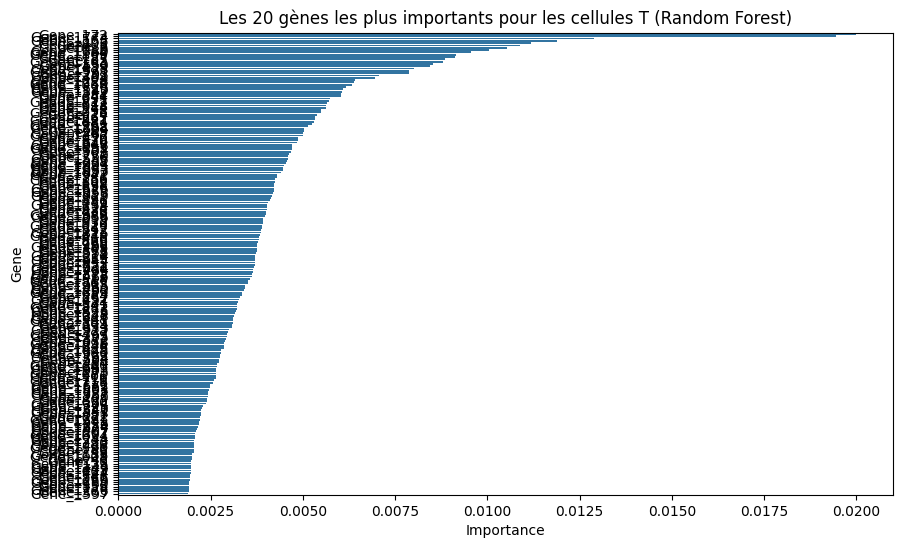

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns

# Exemple de données fictives (remplace avec tes vraies données)
# X_train : gènes (chaque colonne est un gène, chaque ligne une cellule)
# y_train : étiquettes des classes (ici, les cellules T)
X_train = np.random.randn(100, 2000)  # Exemple : 100 échantillons, 2000 gènes
y_train = np.random.choice(['T_cells_CD4+', 'T_cells_CD8+', 'Cancer_cells', 'NK_cells'], 100)

# Convertir en DataFrame pour faciliter l'analyse
gene_names = [f"Gene_{i+1}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=gene_names)
y_train_df = pd.Series(y_train)

# Sélectionner uniquement les cellules T
T_cells_indices = y_train_df.isin(['T_cells_CD4+', 'T_cells_CD8+'])
X_train_tcells = X_train_df[T_cells_indices]
y_train_tcells = y_train_df[T_cells_indices]

# Diviser les données en train/test (80/20)
X_train_tcells, X_test_tcells, y_train_tcells, y_test_tcells = train_test_split(
    X_train_tcells, y_train_tcells, test_size=0.2, random_state=42
)

# Entraîner un Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tcells, y_train_tcells)

# Extraire l'importance des gènes
feature_importances = rf.feature_importances_

# Créer un DataFrame avec l'importance des gènes
importance_df = pd.DataFrame({
    'Gene': gene_names,
    'Importance': feature_importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 gènes les plus importants
print(importance_df.head(10))

# Visualisation des 20 gènes les plus importants
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Gene', data=importance_df.head(200))
plt.title("Les 20 gènes les plus importants pour les cellules T (Random Forest)")
plt.show()


/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/h2/9ggxct057yb8cggcxrpf4p640000gn/T/ipykernel_89451/2765498005.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
/var/folders/

ValueError: num must be an integer with 1 <= num <= 10, not 11

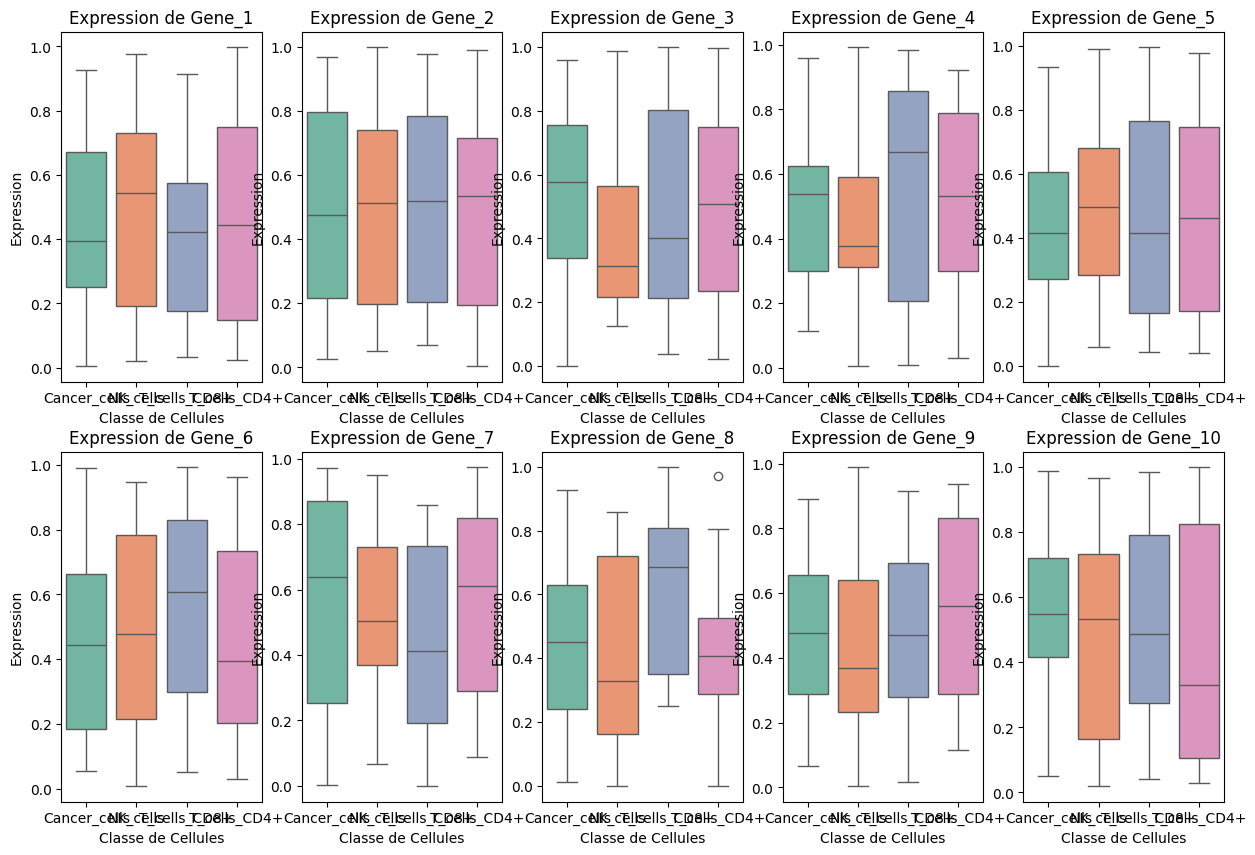

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de données d'expression des gènes (matrice d'expression)
# X_train : matrice de taille (n_samples, n_genes)
# y_train : vecteur de taille (n_samples,) contenant les classes des cellules

# Ici, nous supposons que X_train contient des valeurs d'expression pour chaque gène (exemple aléatoire)
import numpy as np

# Exemple fictif de données
np.random.seed(42)
n_samples = 100
n_genes = 100

# Matrice d'expression (n_samples, n_genes)
X_train = np.random.rand(n_samples, n_genes)

# Étiquettes des classes (par exemple, les 4 classes : T_cells_CD4+, T_cells_CD8+, Cancer_cells, NK_cells)
y_train = np.random.choice(['T_cells_CD4+', 'T_cells_CD8+', 'Cancer_cells', 'NK_cells'], size=n_samples)

# Conversion en DataFrame pour faciliter la manipulation
df = pd.DataFrame(X_train, columns=[f'Gene_{i+1}' for i in range(n_genes)])
df['Cell Class'] = y_train  # Ajout des étiquettes de classe

# Création d'un boxplot pour chaque gène
plt.figure(figsize=(15, 10))

# Pour chaque gène, créer un box plot
for i, gene in enumerate(df.columns[:-1]):  # Exclure la colonne 'Cell Class'
    plt.subplot(2, 5, i+1)  # Créer une grille de subplots (2 lignes, 5 colonnes)
    
    # Créer le boxplot pour ce gène, en fonction des classes de cellules
    sns.boxplot(x='Cell Class', y=gene, data=df, palette='Set2')
    
    plt.title(f"Expression de {gene}")
    plt.xlabel("Classe de Cellules")
    plt.ylabel("Expression")

plt.tight_layout()  # Ajuster l'espacement entre les graphiques
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  # Import de LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif  # Import de SelectKBest

# ---------------- Preprocessor ----------------
class Preprocessor:
    def __init__(self, k_best_features=5500):
        self.k_best_features = k_best_features  # Nombre de caractéristiques à sélectionner
        self.selector = SelectKBest(score_func=f_classif, k=self.k_best_features)  # Sélecteur de caractéristiques

    def fit(self, X, y):
        # Transformation logarithmique
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X_df = pd.DataFrame(X)
        y_df = pd.Series(y)

        # Équilibrage des classes (oversampling)
        class_counts = y_df.value_counts()
        max_size = class_counts.max()
        X_bal, y_bal = [], []

        for label in class_counts.index:
            X_c = X_df[y_df == label]
            y_c = y_df[y_df == label]
            n_dup = max_size - len(X_c)
            if n_dup > 0:
                X_dup = X_c.sample(n=n_dup, replace=True, random_state=42)
                y_dup = y_c.sample(n=n_dup, replace=True, random_state=42)
                X_bal.append(pd.concat([X_c, X_dup]))
                y_bal.append(pd.concat([y_c, y_dup]))
            else:
                X_bal.append(X_c)
                y_bal.append(y_c)

        # Concaténer et mélanger
        X_bal = pd.concat(X_bal).sample(frac=1, random_state=42)
        y_bal = pd.concat(y_bal).sample(frac=1, random_state=42)
        X_bal = np.array(X_bal)

        # Sélection des meilleures caractéristiques avec SelectKBest
        X_bal = self.selector.fit_transform(X_bal, y_bal)  # Sélectionner les k meilleures caractéristiques

        self.X_train_ = X_bal
        self.y_train_ = y_bal.values
        return self

    def transform(self, X):
        X = np.log1p(X.toarray() if hasattr(X, "toarray") else X)
        X = self.selector.transform(X)  # Sélectionner les mêmes caractéristiques sur le test set
        return X


# ---------------- Classifier ----------------
class HClassifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.model = LogisticRegression(random_state=42, max_iter=1000)  # Utilisation de LogisticRegression

    def fit(self, X, y):
        # Appliquer le préprocesseur (normalisation, imputation, sélection des caractéristiques)
        self.preprocessor.fit(X, y)

        # Paramètres pour GridSearchCV
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],  # Paramètre de régularisation (inversé)
            'penalty': ['l2', 'elasticnet'],  # Types de régularisation (L2 ou Elasticnet)
            'solver': ['lbfgs', 'liblinear', 'saga'],  # Solveurs différents
            'max_iter': [500, 1000],  # Nombre d'itérations maximales pour la convergence
            'multi_class': ['ovr', 'multinomial']  # Méthode pour gérer la classification multiclasse
        }

        # GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(self.model, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
        grid_search.fit(self.preprocessor.X_train_, self.preprocessor.y_train_)

        # Récupérer le meilleur modèle
        self.model = grid_search.best_estimator_
        print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.model.predict_proba(X_proc)


# ---------------- Hierarchical Classifier ----------------
class Classifier:
    def __init__(self):
        # Étape 1 : séparer les groupes
        self.clf_step1 = HClassifier()
        # Étape 2 : classifier à l'intérieur des groupes
        self.clf_step2_group1 = HClassifier()  # Cancer vs NK
        self.clf_step2_group2 = HClassifier()  # CD4+ vs CD8+

    def fit(self, X, y):
        y_step1 = np.array([0 if label in ['Cancer_cells','NK_cells'] else 1 for label in y])
        self.clf_step1.fit(X, y_step1)

        # Sous-groupe 1 : Cancer vs NK
        mask_group1 = np.array([label in ['Cancer_cells','NK_cells'] for label in y])
        self.clf_step2_group1.fit(
            X[mask_group1],
            np.array([0 if label=='Cancer_cells' else 1 for label in y[mask_group1]])
        )

        # Sous-groupe 2 : CD4+ vs CD8+
        mask_group2 = np.array([label in ['T_cells_CD4+','T_cells_CD8+'] for label in y])
        self.clf_step2_group2.fit(
            X[mask_group2],
            np.array([0 if label=='T_cells_CD4+' else 1 for label in y[mask_group2]])
        )

    def predict(self, X):
        step1_pred = self.clf_step1.predict(X)
        final_pred = np.array([""]*len(step1_pred), dtype=object)

        # Sous-groupe 1
        idx_group1 = np.where(step1_pred==0)[0]
        if len(idx_group1) > 0:
            pred_group1 = self.clf_step2_group1.predict(X[idx_group1])
            final_pred[idx_group1] = ["Cancer_cells" if p==0 else "NK_cells" for p in pred_group1]

        # Sous-groupe 2
        idx_group2 = np.where(step1_pred==1)[0]
        if len(idx_group2) > 0:
            pred_group2 = self.clf_step2_group2.predict(X[idx_group2])
            final_pred[idx_group2] = ["T_cells_CD4+" if p==0 else "T_cells_CD8+" for p in pred_group2]

        return final_pred


# ---------------- Exemple d'utilisation ----------------
# Supposons que tu as déjà tes données : X_train, y_train, X_test, y_test
hier_clf = Classifier()
hier_clf.fit(X_train, y_train)

# Prédiction
y_pred = hier_clf.predict(X_test)

# Évaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", bal_acc)

cm = confusion_matrix(
    y_test, y_pred,
    labels=['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']
)
print("Confusion Matrix:\n", cm)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier

Best parameters from GridSearchCV: {'C': 1, 'max_iter': 500, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/eliko/Documents/M2DS/Data Comp/scmark-classification-team_avengers/venAvenger/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   33    45   163   220   222   287   490   515   535   845  1279  1305
  1306  1327  1434  1450  1460  1558  1786  1823  1830  1864  1891  1943
  2220  2301  2303  2374  2431  2441  2594  2632  2645  2693  2780  3076
  3097  3338  3417  3663  3806  3856  3926  3927  4066  4130  4156  4166
  4277  4459  4545  4559  4612  4653  4671  4996  5095  5098  5289  5325
  5433  5547  5588  5590  5605  5617  5747  6006  6008  6027  6043  6055
  6088  6195  6227  6537  7278  7416  7811  7828  7833  7967  7984  8044
  8088  8357  8434  8552  8556  8695  8763  8822  9196  9358  9451  9560
  9576  9598  9605  9608  9614  9615  9633  9647  9675  9687  9688  9703
  9715  9716  9717  9908 10131 10139 10150 10391 10746 10823 11052 11225
 11303 11430 11602 11608 11760 11878 12177 12270 12409 12497 12760 12762
 1287

KeyboardInterrupt: 